<a href="https://colab.research.google.com/github/Shashwat17-vit/opencv/blob/master/TomatoCNNUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32
    y_pred = K.cast(y_pred, 'float32')  # Ensure y_pred is float32

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(image_dir, img_size=(1400, 875)):
    images = []

    image_files = sorted(os.listdir(image_dir))  # Ensure matching order with masks

    for img_file in image_files:
        # Load and preprocess the image
        img_path = os.path.join(image_dir, img_file)

        img = load_img(img_path, target_size=img_size)  # Resize image

        img = img_to_array(img) / 255.0  # Normalize image

        images.append(img)

    return np.array(images)

In [9]:
image_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train"
img_size = (1400, 875)  # Input size for U-Net

images = load_images(image_dir, img_size)

print(f"Loaded {len(images)} images")
print(f"Image shape: {images[0].shape}")

Loaded 17 images
Image shape: (1400, 875, 3)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [11]:
## Decoding the Run-Length Encoded Mask

import numpy as np
HEIGHT = 1400
WIDTH = 875

mask_read=pd.read_csv("drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train.csv")

mask=mask_read['annotation']


def rl_decode(enc):
    parts = [int(s) for s in enc.split(' ')]
    dec = list()
    for i in range(0, len(parts), 2):
        cnt = parts[i]
        val = parts[i+1]
        dec += cnt * [val]
    return np.array(dec, dtype=np.uint8).reshape((HEIGHT, WIDTH))

decoded_masks=[]

for item in mask:
    np_mask=rl_decode(item)
    decoded_masks.append(np_mask)

decoded_masks = np.array(decoded_masks)
print(decoded_masks)

out=pd.DataFrame(decoded_masks[0])

#output=pd.DataFrame({'id':test_data.id,'Target':XGB_submit})
#output["Target"]=output['Target'].map({0:'Dropout',1:'Enrolled',2:'Graduate'})
out.to_csv('Check',index=False)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


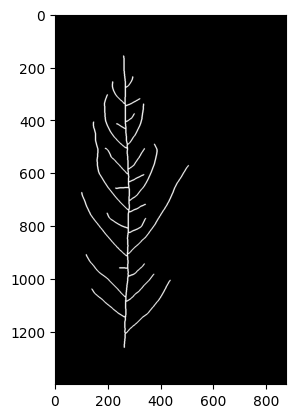

In [7]:
if len(decoded_masks.shape) == 3:  # Shape (batch_size, height, width)
    thresholded_predictions = (decoded_masks[1] > 0.5).astype(np.uint8)
    plt.imshow(thresholded_predictions, cmap='gray')
elif len(decoded_masks.shape) == 4:  # Shape (batch_size, height, width, channels)
    thresholded_predictions = (decoded_masks[1] > 0.5).astype(np.uint8)
    plt.imshow(thresholded_predictions[:, :, 0], cmap='gray')
else:
    raise ValueError("Unexpected shape of decoded_masks:", decoded_masks.shape)

In [12]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_val, y_train, y_val = train_test_split(images, decoded_masks, test_size=0.2, random_state=42)

# Fit U-Net
#model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)

In [9]:
def unet_for_leaf(input_shape=(1400, 875, 3)):
    # Sequential-like layers for U-Net
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    # Encoder
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((5, 5)))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((5, 5)))

    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 1)))

    # Bottleneck
    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))

    # Decoder
    model.add(tf.keras.layers.UpSampling2D((2, 1)))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

    model.add(tf.keras.layers.UpSampling2D((5, 5)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

    model.add(tf.keras.layers.UpSampling2D((5, 5)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid'))

    return model

input_shape = (1400, 875, 3)
unet_model = unet_for_leaf(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryIoU()])
unet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1400, 875, 64)       │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1400, 875, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 280, 175, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 280, 175, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 280, 175, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 35, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 35, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 35, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 35, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 35, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 56, 35, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 35, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 35, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 280, 175, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 280, 175, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 280, 175, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 1400, 875, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 1400, 875, 64)       │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 1400, 875, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 1400, 875, 1)        │              65 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,008,769 (26.74 MB)

 Trainable params: 7,008,769 (26.74 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
class StopAndTestCallback(tf.keras.callbacks.Callback):
    def __init__(self, stop_epoch):
        super().__init__()
        self.stop_epoch = stop_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 == self.stop_epoch:
            print(f"\nStopping training at epoch {self.stop_epoch}")
            self.model.stop_training = True

NameError: name 'tf' is not defined

In [22]:
images=images[0]
decoded_masks=decoded_masks[0]

(1400, 875)


In [24]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.weights.h5',  # Save path
    save_best_only=True,            # Save the model at every epoch
    save_weights_only=True           # Save weights instead of the full model
)
stop_epoch = 5

model_main= unet_model.fit(images, decoded_masks,epochs=5,batch_size=1, verbose=1,callbacks=[checkpoint_callback,StopAndTestCallback(stop_epoch)])

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - binary_io_u: 0.4909 - loss: 0.2842
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - binary_io_u: 0.4908 - loss: 0.2871
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - binary_io_u: 0.4905 - loss: 0.2968
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - binary_io_u: 0.4905 - loss: 0.2948
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - binary_io_u: 0.4903 - loss: 0.3041
Stopping training at epoch 5
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - binary_io_u: 0.4902 - loss: 0.3038


(3, 1400, 875, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(1400, 875, 1)


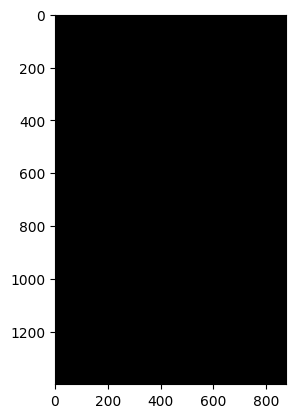

In [33]:
image_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/single"
img_size = (1400, 875)  # Input size for U-Net

images_test = load_images(image_dir, img_size)


print(images_test.shape)  # Should be (1, 875, 1400, 3) for a single image

predictions = unet_model.predict(images_test)

print(predictions[0].shape)  # Should be (1, 875, 1400, 3) for a single image

reshaped_predictions = predictions[0][:, :, 0]  # Remove the batch and channel dimensions
np.savetxt('predictions.txt', reshaped_predictions)

thresholded_predictions = (predictions[0] > 0.5).astype(np.uint8)


import matplotlib.pyplot as plt

plt.imshow(thresholded_predictions[:, :, 0], cmap='gray')  # For binary segmentation
plt.show()


In [30]:
print(predictions.shape)

reshaped_predictions = predictions[0, :, :, 0]  # Remove the batch and channel dimensions
np.savetxt('predictions.txt', reshaped_predictions)

import matplotlib.pyplot as plt

plt.imshow(thresholded_predictions[0, :, :, 0])  # For binary segmentation
plt.show()

(3, 1400, 875, 1)


ValueError: Expected 1D or 2D array, got 3D array instead

In [ ]:
model_main= unet_model.fit(images, decoded_masks, epochs=10, initial_epoch=stop_epoch, verbose=2)

In [ ]:
# Save the entire model (architecture, weights, optimizer)
unet_model.save('unet_model_epoch2.h5')  # You can use any name for the file


(2, 1400, 875, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
(2, 1400, 875, 1)


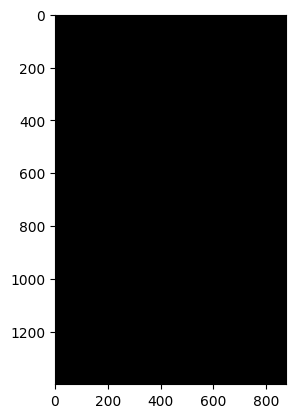

In [15]:
image_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/single/"
img_size = (1400, 875)  # Input size for U-Net

images_test = load_images(image_dir, img_size)


print(images_test.shape)  # Should be (1, 875, 1400, 3) for a single image

predictions = unet_model.predict(images_test)

print(predictions.shape)  # Should be (1, 875, 1400, 3) for a single image

thresholded_predictions = (predictions > 0.5).astype(np.uint8)


import matplotlib.pyplot as plt

plt.imshow(predictions[0, :, :, 0], cmap='gray')  # For binary segmentation
plt.show()